In [3]:
import pandas as pd
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# data load

In [4]:
filedir = "/public/hanl/jupyter_dir/ir_recommend_v2/01.action/"
infile = filedir + '/A_IR_win60.csv'
df_ac = pd.read_csv(infile)
df_ac["starttime"] = pd.to_datetime(df_ac["starttime"])
df_ac["endtime"] = pd.to_datetime(df_ac["endtime"])
print(df_ac.head(2))

filedir = "/public/hanl/jupyter_dir/ir_recommend_v2/00.data/"
infile = filedir + '/ir_icu_glucose.csv'
df_glu = pd.read_csv(infile)
df_glu["charttime"] = pd.to_datetime(df_glu["charttime"])
print(df_glu.head(2))

    stay_id           starttime             endtime  amount  rate  interval  \
0  30001148 2156-08-30 19:15:00 2156-08-30 20:15:00     2.0   2.0      60.0   
1  30001148 2156-08-30 20:15:00 2156-08-30 21:15:00     2.0   2.0      60.0   

   traj_id  
0        1  
1        1  
    stay_id           charttime  glucose
0  39060235 2160-05-18 10:26:00    216.0
1  39060235 2160-05-18 11:23:00    177.0


# 保留state时间前20分钟和后1小时的血糖记录

In [7]:
df_ac_addglu = pd.merge(df_glu, df_ac, how="inner",on="stay_id")
df_ac_addglu["bg_interval"] = (df_ac_addglu["charttime"] - df_ac_addglu["starttime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
df_ac_addglu = df_ac_addglu[df_ac_addglu["bg_interval"] >= -20]
df_ac_addglu["ed_interval"] = (df_ac_addglu["charttime"] - df_ac_addglu["endtime"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
df_ac_addglu = df_ac_addglu[df_ac_addglu["ed_interval"] <= 1]
df_ac_addglu =df_ac_addglu.drop(["bg_interval","ed_interval","interval"],axis=1)

df_ac_addglu = df_ac_addglu.sort_values(["stay_id","starttime","charttime"])
df_ac_addglu['rank'] = range(len(df_ac_addglu))
df_ac_addglu.to_csv("df_ac_addglu_b20_a60m.csv",index=False)

# 字典-每个state相关的血糖 根据reward设计划分成平稳控制，快速控制

In [31]:
def control_interval(id_, glu_lst, t_lst):
    hypo_lst =[]
    control_dict ={}
    control_dict[id_] = {}
    control_dict[id_]["fast_control"] = []
    control_dict[id_]["fast_control_t"] = []
    control_dict[id_]["steady_control"] = []
    control_dict[id_]["steady_control_t"] = []

    last_glu = glu_lst[0]
    last_t = t_lst[0]
    if last_glu <= 70:
        hypo_lst.append(last_glu)
    
    tmp2_lst = [last_t]
    tmp_lst = [last_glu]
    idx = 0
    for glu in glu_lst[1:]: # 蹦到第一个glu>180,或 第一个<180的记录，更新lst
        idx += 1
        tmp_lst.append(glu)
        tmp2_lst.append(t_lst[idx])
        
        if glu <= 70:
            hypo_lst.append(glu)
        
        if glu >= 180 and last_glu<180: # print("stedy", last_glu, glu)
            control_dict[id_]["steady_control"].append(tmp_lst)
            control_dict[id_]["steady_control_t"].append(tmp2_lst)
            last_glu = glu
            tmp_lst = [last_glu]
            
            last_t = t_lst[idx]
            tmp2_lst = [last_t]
            
        if glu < 180 and last_glu >= 180:  # print("fast",last_glu, glu)   
            control_dict[id_]["fast_control"].append(tmp_lst)
            control_dict[id_]["fast_control_t"].append(tmp2_lst)
            last_glu = glu
            tmp_lst = [last_glu]
            
            last_t = t_lst[idx]
            tmp2_lst = [last_t]
            
    if last_glu >= 180:
        control_dict[id_]["fast_control"].append(tmp_lst)
        control_dict[id_]["fast_control_t"].append(tmp2_lst)
    if last_glu < 180:
        control_dict[id_]["steady_control"].append(tmp_lst)
        control_dict[id_]["steady_control_t"].append(tmp2_lst)
        
    control_dict[id_]["hypoglycemia_control"] = hypo_lst
    return control_dict

def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z

In [32]:
df_ac_addglu_60m = pd.read_csv("df_ac_addglu_b20_a60m.csv")
# reward 主要分为两部分： 1）快速控糖，包括多长时间没控制住应罚分+低血糖的罚分； 2）平稳控糖，还包括低血糖的罚分
control_dict_merged = {}

for i,j in df_ac_addglu_60m.groupby(['stay_id', 'starttime', 'endtime', 'rate', "traj_id"]):
    glu_lst = j.glucose.values
    t_lst = j.charttime.tolist()
    id_ = j["rank"].iloc[0]
    control_dict = control_interval(id_, glu_lst, t_lst)
    control_dict_merged = merge_two_dicts(control_dict_merged, control_dict)

import pickle
with open("glucose_control_dict_60m.pkl", "wb") as tf: # run done
    pickle.dump(control_dict_merged, tf)    
# 26min

# CLICK:如果改进 reward function 从此步开始

## 根据interval获得打分

In [33]:
import pickle
with open("glucose_control_dict_60m.pkl", "rb") as tf:
    control_dict_merged = pickle.load(tf)

In [40]:
tmp_df = pd.DataFrame(columns=["id_","fast_control", "fast_score", "steady_control","steady_score"])
tmp_lst = []

for idx in control_dict_merged.keys():    
    control_dict = control_dict_merged[idx]
    if len(control_dict["fast_control"]) > 0 and len(control_dict["fast_control"][0]) > 1: # 如果满足该条件，看第一个异常值与第一个在正常范围的血糖的时间是否超过 规定值，否则罚分
        r_fast_control = func_fast_control(control_dict)
    else:
        r_fast_control = np.nan
        
    if len(control_dict["steady_control"]) > 0  and len(control_dict["steady_control"][0]) > 1:
        r_steady_control = func_steady_control(control_dict)
    else:
        r_steady_control = np.nan
    
    tmp_lst = [idx, control_dict_merged[idx]["fast_control"], r_fast_control, control_dict_merged[idx]["steady_control"], r_steady_control]
    tmp_df.loc[len(tmp_df)] = tmp_lst
#tmp_df.to_csv("R_decomposition_60m.csv", index=False)
# 3h

## final score
- 此时，有action数目：335249；原始action数： 342245
- 经过check，这些损失的action都是因为在半衰期内无血糖记录，无法构建该state的reward

In [41]:
infile = "R_decomposition_60m.csv"

df_r_decomposition = pd.read_csv(infile)
df_r_decomposition["final_score"] = 0

# 这部确定每个state在定义reward时都存在至少一个葡糖记录
print(df_r_decomposition[(df_r_decomposition["fast_control"]=="[]") & (df_r_decomposition["steady_control"]=="[]")].shape)

(0, 6)


In [42]:
# df_p2 指state指代的过程既发生了平稳控糖的过程也发生了快速控糖的过程
df_p2 = df_r_decomposition[(df_r_decomposition["fast_control"].str.contains(",")) & (df_r_decomposition["steady_control"].str.contains(","))]

YN_lst = []
tmp_lst = df_p2["steady_control"].tolist()
for i in tmp_lst:
    i = i.split("],")[0].replace("]","")
    i = i.replace("[","").split(",")
    i = np.array(i)
    i = i.astype(np.float32)
    
    if (i>70).all() and (i <180).all():
        s = "Y"
    if (i>=180).any():
        s = "N"
    if (i<=70).any():
        s = "hypo"
    YN_lst.append(s)
df_p2["S_judge"] = np.array(YN_lst)

YN_lst = []
tmp_lst = df_p2["fast_control"].tolist()
for i in tmp_lst:
    i = i.split("],")[0].replace("]","")
    i = i.replace("[","").split(",")
    i = np.array(i)
    i = i.astype(np.float32)
    if i[0] >= 180 and i[-1]<180:
        s = "Y"
    if i[0] >= 180 and i[-1]>=180:
        s = "N"
    if (i<=70).any():
        s = "hypo"
    YN_lst.append(s)
df_p2["F_judge"] = np.array(YN_lst)

# 两者的判断都为Y或者N，取平均
# 两者的判断存在一个N，reward为判断为N
# 两者 存在湖泊， reward直接取-40

df_p21 = df_p2[(df_p2["F_judge"]== "Y") & (df_p2["S_judge"]== "Y")]
df_p21["final_score"] = (df_p21["fast_score"] + df_p21["steady_score"])/2

df_p22 = df_p2[(df_p2["F_judge"]== "N") & (df_p2["S_judge"]== "N")]
df_p22["final_score"] = (df_p22["fast_score"] + df_p22["steady_score"])/2

df_p23 = df_p2[(df_p2["F_judge"]== "hypo") | (df_p2["S_judge"]== "hypo")]
df_p23["final_score"] = -40

df_p24 = df_p2[(df_p2["F_judge"]== "N") & (df_p2["S_judge"]== "Y")]
df_p24["final_score"] = df_p24["fast_score"]

df_p25 = df_p2[(df_p2["F_judge"]== "Y") & (df_p2["S_judge"]== "N")]
df_p25["final_score"] = df_p25["steady_score"]

df_p2 = pd.concat([df_p21, df_p22, df_p23, df_p24, df_p25 ])
df_p2 = df_p2.drop(["S_judge", "F_judge"], axis=1)

In [43]:
# df_ps 指平稳控糖的过程，此时fast_control为“[]”， final_score  = steady_score
df_ps1 = df_r_decomposition[(df_r_decomposition["fast_control"]=="[]") & df_r_decomposition["steady_control"].str.contains(",")]
df_ps2 = df_r_decomposition[~(df_r_decomposition["steady_control"].str.contains(",")) & ~(df_r_decomposition["steady_control"] == "[]") & (df_r_decomposition["fast_control"] == "[]") ]
df_ps3 =  df_r_decomposition[~(df_r_decomposition["fast_control"].str.contains(",")) & ~(df_r_decomposition["fast_control"] == "[]") & (df_r_decomposition["steady_control"].str.contains(",")) ]

df_ps = pd.concat([df_ps1, df_ps2, df_ps3])
df_ps["final_score"] = df_ps["steady_score"]
df_ps.head(2)
print(df_ps1.shape, df_ps2.shape,df_ps3.shape, df_ps.shape)

(170828, 6) (34870, 6) (5833, 6) (211531, 6)


In [44]:
# df_ps 指快速控糖的过程，此时fast_control为“[]”， final_score  = fast_score
df_pf1 = df_r_decomposition[(df_r_decomposition["steady_control"]=="[]") & df_r_decomposition["fast_control"].str.contains(",")]
df_pf2 = df_r_decomposition[~(df_r_decomposition["fast_control"].str.contains(",")) & ~(df_r_decomposition["fast_control"] == "[]") & (df_r_decomposition["steady_control"] == "[]") ]
df_pf3 = df_r_decomposition[~(df_r_decomposition["steady_control"].str.contains(",")) & ~(df_r_decomposition["steady_control"] == "[]") & (df_r_decomposition["fast_control"].str.contains(",")) ]

df_pf = pd.concat([df_pf1, df_pf2, df_pf3])
df_pf["final_score"] = df_pf["fast_score"]
df_pf.head(2)
print(df_pf1.shape, df_pf2.shape, df_pf3.shape, df_pf.shape)

(24181, 6) (6050, 6) (9520, 6) (39751, 6)


In [45]:
print(df_ps.shape, df_pf.shape, df_p2.shape)

(211531, 6) (39751, 6) (11039, 6)


In [66]:
'''# 合并校正后的final reward
df_ps["control_type"] = "S"
df_pf["control_type"] = "F"
df_p2["control_type"] = "B"

df_r_combined = pd.concat([df_ps, df_pf, df_p2])
print(df_r_decomposition.shape[0], df_p2.shape[0] +df_ps.shape[0]+df_pf.shape[0])
# check final score 按类修改后数量上是否差异
pd.concat([df_r_decomposition, df_r_combined, df_r_combined]).drop_duplicates(keep=False, subset=['id_']) '''

332958 332958


,id_,fast_control,fast_score,steady_control,steady_score,final_score,control_type


In [47]:
# 只保留单一的快速控糖或者平稳控糖过程
df_ps["control_type"] = "S"
df_pf["control_type"] = "F"
print(df_r_decomposition.shape[0], df_ps.shape[0]+df_pf.shape[0])

df_r_combined = pd.concat([df_ps, df_pf])

262321 251282


## 生成最后的reward 文件

In [50]:
df_r_combined_cut = df_r_combined.loc[:,["id_", "final_score"]]
df_r_combined_cut = df_r_combined_cut[~df_r_combined_cut[["final_score"]].isnull().T.any()]

df_ac_addglu_60m = pd.read_csv("df_ac_addglu_b20_a60m.csv")
tmp_df = df_ac_addglu_60m.loc[:,['stay_id', 'starttime', 'endtime', 'rate',"rank","traj_id"]]

df_reward = pd.merge(df_r_combined_cut,tmp_df,how="left", left_on = "id_", right_on= "rank" )
df_reward = df_reward.drop(["id_", "rank"], axis = 1)
df_reward[df_reward.isnull().T.any()]

,final_score,stay_id,starttime,endtime,rate,traj_id


In [52]:
df_reward.columns = ['reward', 'stay_id', 'starttime', 'endtime', 'rate',"traj_id"]
df_reward.to_csv("R_v8.csv", index= False)

In [53]:
df_reward.head(1)

,reward,stay_id,starttime,endtime,rate,traj_id
0,5.3125,30001148,2156-08-30 20:15:00,2156-08-30 21:15:00,2.0,1


In [17]:
##################
df_reward = pd.read_csv("R_v8.csv")
print(df_reward.shape)
df_reward.head(1)

(261160, 6)


,reward,stay_id,starttime,endtime,rate,traj_id
0,14.625,30000213,2162-06-21 05:40:00,2162-06-21 06:06:00,8.0,0


## 生成最后的校正后的reward组成文件

In [59]:
df_r_combined.head(1)

,id_,fast_control,fast_score,steady_control,steady_score,final_score,control_type
1,1,[],NaN,"[[109.0, 86.0]]",5.3125,5.3125,S


In [60]:
tmp_df = df_r_combined.drop(["control_type"],axis =1)
tmp_df.to_csv("R_decomposition_60m_addR.csv", index=False)
tmp_df.head(1)

,id_,fast_control,fast_score,steady_control,steady_score,final_score
1,1,[],NaN,"[[109.0, 86.0]]",5.3125,5.3125


## 生成包含组成的reward 文件

In [85]:
df_r_combined_add = pd.merge(df_r_combined, df_sc_stat, how="left", on = ['id_', 'steady_control', 'steady_score'])
df_r_combined_add = pd.merge(df_r_combined_add, df_fc_stat, how="left", on = ['id_', 'fast_control', 'fast_score'])
df_r_combined_add.loc[(df_r_combined_add["control_type"]=="S"), "fast_type"] = np.nan
df_r_combined_add.loc[(df_r_combined_add["control_type"]=="F"), "steady_type"] = np.nan
df_r_combined_add.head(2)

,id_,fast_control,fast_score,steady_control,steady_score,final_score,control_type,steady_type,fast_type
0,1,[],NaN,"[[109.0, 86.0]]",5.3125,5.3125,S,TT,NaN
1,3,[],NaN,"[[86.0, 104.0]]",4.3750,4.3750,S,TT,NaN


In [86]:
df_ac_addglu_60m = pd.read_csv("df_ac_addglu_b20_a60m.csv")
tmp_df = df_ac_addglu_60m.loc[:,['stay_id', 'starttime', 'endtime', 'rate',"rank", "traj_id"]]
tmp_df.head(2)

,stay_id,starttime,endtime,rate,rank,traj_id
0,30001148,2156-08-30 19:15:00,2156-08-30 20:15:00,2.0,0,1
1,30001148,2156-08-30 20:15:00,2156-08-30 21:15:00,2.0,1,1


In [87]:
df_reward2 = pd.merge(df_r_combined_add, tmp_df,how="left", left_on = "id_", right_on= "rank" )
df_reward2 = df_reward2.loc[:,[ 'stay_id', 'traj_id', 'starttime', 'endtime',  'rate', 'fast_control', 'fast_score', 'steady_control', 'steady_score',
       'final_score', 'steady_type', 'fast_type',"control_type"]]
df_reward2 = df_reward2.rename(columns={'final_score':'reward'})
df_reward2.to_csv("R_decomposition_60m_add.csv", index=False)

In [88]:
df_reward2.shape

(251282, 13)

# 统计

## steady control 统计

In [67]:
df_r_decomposition_30m = pd.read_csv("R_decomposition_60m_addR.csv")
df_s = df_r_decomposition_30m.loc[:,["id_", "steady_control", "steady_score"]]

In [68]:
tmp_df = pd.DataFrame(columns=["id_", "steady_control", "steady_score", "steady_type"])
for row in df_s.itertuples():
    tmp_str = row.steady_control.replace("[", "")
    tmp_str = tmp_str.replace("]", "")
    tmp_str = tmp_str.replace(" ", "")
    if len(tmp_str) > 0:
        lst = np.array(tmp_str.split(","))
        lst  =lst.astype(np.float32)

        if (lst > 70).all() and (lst < 180).all(): # 全部在正常范围内
            Type = "TT"
        if (lst >= 110).any() and (lst <= 140).any(): # 部分在理想范围内
            Type = "TD"
        if (lst >= 180).any():
            Type = "TH"
        if (lst <= 70).any():
            Type = "TL"
    out_lst = [row.id_, row.steady_control, row.steady_score, Type]
    tmp_df.loc[len(tmp_df)] = out_lst
#tmp_df.to_csv("steady_control_stat_60m.csv",index=False)
# 1.19h

In [69]:
df_sc_stat = pd.read_csv("steady_control_stat_60m.csv")
df_sc_stat = df_sc_stat[df_sc_stat["steady_control"]!="[]"]
df_sc_stat.head(2)

# 统计
df_sc_stat_merged = df_sc_stat.groupby("steady_type")
for i, j in df_sc_stat_merged:
    print("---------------")
    print(i, " ", j.shape[0])

---------------
TD   140228
---------------
TH   5755
---------------
TL   4570
---------------
TT   70498


In [80]:
TT = df_sc_stat[df_sc_stat["steady_type"] == "TT"]["steady_score"]
TD = df_sc_stat[df_sc_stat["steady_type"] == "TD"]["steady_score"]
TL = df_sc_stat[df_sc_stat["steady_type"] == "TL"]["steady_score"]
TH = df_sc_stat[df_sc_stat["steady_type"] == "TH"]["steady_score"]

print(TT.describe(),"\n",TD.describe(),"\n", TL.describe(), "\n",TH.describe())

import math
TT = [x for x in TT if math.isnan(x) == False]
TD = [x for x in TD if math.isnan(x) == False]
TL = [x for x in TL if math.isnan(x) == False]
TH = [x for x in TH if math.isnan(x) == False]

count    42978.000000
mean         5.963543
std          4.744025
min         -9.250000
25%          3.437500
50%          5.875000
75%          8.375000
max         19.250000
Name: steady_score, dtype: float64 
 count    123758.000000
mean         15.787516
std           3.927087
min          -7.500000
25%          13.000000
50%          16.041667
75%          20.000000
max          20.000000
Name: steady_score, dtype: float64 
 count    4170.000000
mean      -25.321289
std        10.128099
min       -40.000000
25%       -34.125000
50%       -25.984375
75%       -20.000000
max         6.208333
Name: steady_score, dtype: float64 
 count    5755.000000
mean       -9.424544
std         6.647598
min       -35.250000
25%       -14.062500
50%       -10.796296
75%        -4.288194
max        11.820988
Name: steady_score, dtype: float64


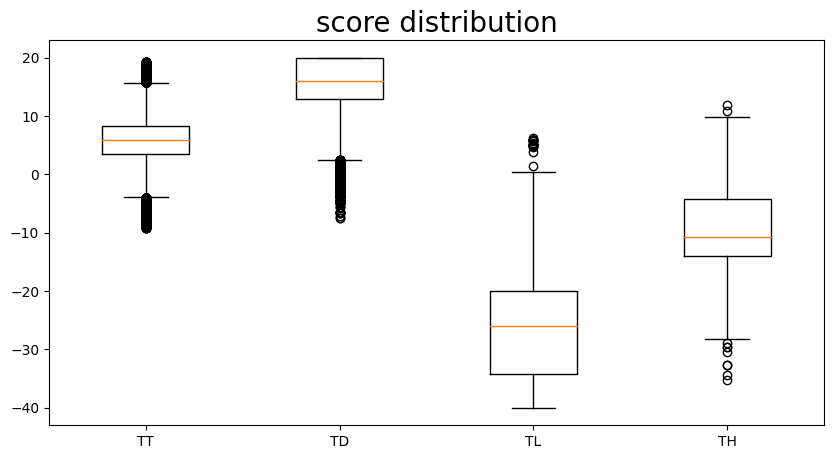

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
 
box_1, box_2, box_3, box_4  = TT, TD, TL, TH
 
plt.figure(figsize=(10,5)) # 设置画布的尺寸
plt.title("score distribution",fontsize=20) # 标题，并设定字号大小
labels = "TT", "TD", "TL", "TH"#图例
plt.boxplot([box_1, box_2, box_3, box_4], labels = labels)# grid=False：代表不显示背景中的网格线
plt.show() # 显示图像

## fast control 统计

In [81]:
df_r_decomposition = pd.read_csv("R_decomposition_60m_addR.csv")
df_f = df_r_decomposition.loc[:,["id_", 'fast_control', 'fast_score']]
df_f = df_f[df_f["fast_control"]!="[]"]
df_f.head(2)

,id_,fast_control,fast_score
205698,335,[[205.0]],NaN
205699,338,[[205.0]],NaN


In [63]:
tmp_df = pd.DataFrame(columns=["id_", "fast_control", "fast_score", "fast_type"])
for row in df_f.itertuples():
    tmp_str = row.fast_control.replace("[", "")
    tmp_str = tmp_str.replace("]", "")
    tmp_str = tmp_str.replace(" ", "")
    if len(tmp_str) > 0:
        lst = np.array(tmp_str.split(","))
        lst  =lst.astype(np.float32)
        G1 = lst[0]
        GN = lst[-1]
       # print(G1,GN)
        if GN < G1 and GN >= 180: # 降了血糖但降糖后 还是大于180
            Type = "HH"
        if GN >= G1: # GN,G1 都大于180
            Type = "HMH"
        if GN < G1 and GN < 180 and GN >= 70: # 降血糖到正常范围
            Type = "HT"
        if GN < G1 and (lst<70).any(): # 降血糖到低血糖范围
            Type = "HL"
            
    out_lst = [row.id_, row.fast_control, row.fast_score, Type]
    tmp_df.loc[len(tmp_df)] = out_lst
#tmp_df.to_csv("fast_control_stat_60m.csv",index=False)

In [82]:
df_fc_stat = pd.read_csv("fast_control_stat_60m.csv")
df_fc_stat = df_fc_stat[df_fc_stat["fast_score"]!=0.000000]
print(df_fc_stat.head(4))

# 统计
df_fc_stat_merged = df_fc_stat.groupby("fast_type")
for i, j in df_fc_stat_merged:
    print("---------------")
    print(i, " ", j.shape[0])
 #   print(j)

   id_ fast_control  fast_score fast_type
0  335    [[205.0]]         NaN       HMH
1  338    [[205.0]]         NaN       HMH
2  382    [[190.0]]         NaN       HMH
3  413    [[185.0]]         NaN       HMH
---------------
HH   8254
---------------
HL   20
---------------
HMH   20242
---------------
HT   5594


In [83]:
HH = df_fc_stat[df_fc_stat["fast_type"] == "HH"]["fast_score"]
HMH = df_fc_stat[df_fc_stat["fast_type"] == "HMH"]["fast_score"]
HT = df_fc_stat[df_fc_stat["fast_type"] == "HT"]["fast_score"]
HL = df_fc_stat[df_fc_stat["fast_type"] == "HL"]["fast_score"]

print(HH.describe(),"\n",HMH.describe(),"\n", HT.describe(), "\n",HL.describe())

import math
HH = [x for x in HH if math.isnan(x) == False]
HMH = [x for x in HMH if math.isnan(x) == False]
HT = [x for x in HT if math.isnan(x) == False]
HL = [x for x in HL if math.isnan(x) == False]

count    8254.000000
mean        1.728637
std         6.908335
min       -10.000000
25%        -6.666667
50%         2.111111
75%         6.000000
max        20.000000
Name: fast_score, dtype: float64 
 count    8359.000000
mean      -12.962791
std         3.240767
min       -40.000000
25%       -14.000000
50%       -12.000000
75%       -10.777778
max       -10.000000
Name: fast_score, dtype: float64 
 count    5594.000000
mean        3.709994
std         5.879411
min       -10.000000
25%         1.103020
50%         3.507472
75%         6.888889
max        20.000000
Name: fast_score, dtype: float64 
 count    20.000000
mean    -22.000000
std      15.078741
min     -40.000000
25%     -40.000000
50%     -10.000000
75%     -10.000000
max     -10.000000
Name: fast_score, dtype: float64


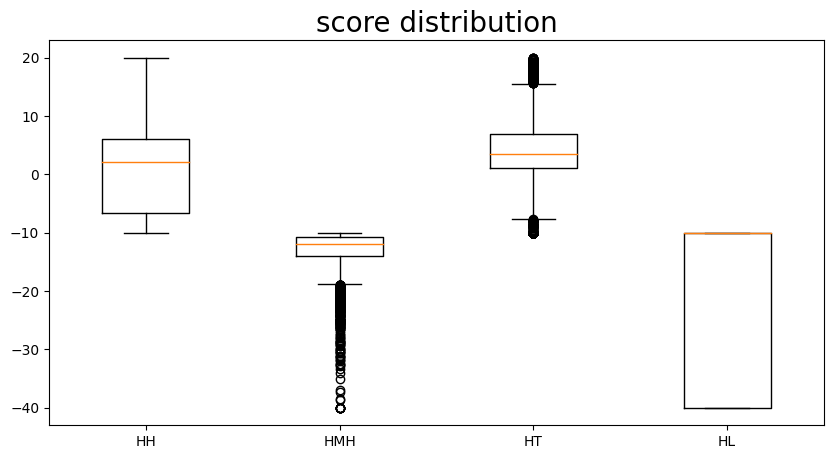

In [84]:
# HH, HMH, HT, HL
import pandas as pd
import matplotlib.pyplot as plt
 
box_1, box_2, box_3, box_4  = HH, HMH, HT, HL
 
plt.figure(figsize=(10,5)) # 设置画布的尺寸
plt.title("score distribution",fontsize=20) # 标题，并设定字号大小
labels = "HH", "HMH", "HT", "HL" #图例
plt.boxplot([box_1, box_2, box_3, box_4], labels = labels)# grid=False：代表不显示背景中的网格线
plt.show() # 显示图像

# def (需要预先加载)

In [17]:
def control_interval(id_, glu_lst, t_lst):
    hypo_lst =[]
    control_dict ={}
    control_dict[id_] = {}
    control_dict[id_]["fast_control"] = []
    control_dict[id_]["fast_control_t"] = []
    control_dict[id_]["steady_control"] = []
    control_dict[id_]["steady_control_t"] = []

    last_glu = glu_lst[0]
    last_t = t_lst[0]
    if last_glu <= 70:
        hypo_lst.append(last_glu)
    
    tmp2_lst = [last_t]
    tmp_lst = [last_glu]
    idx = 0
    for glu in glu_lst[1:]: # 蹦到第一个glu>180,或 第一个<180的记录，更新lst
        idx += 1
        tmp_lst.append(glu)
        tmp2_lst.append(t_lst[idx])
        
        if glu <= 70:
            hypo_lst.append(glu)
        
        if glu >= 180 and last_glu<180: # print("stedy", last_glu, glu)
            control_dict[id_]["steady_control"].append(tmp_lst)
            control_dict[id_]["steady_control_t"].append(tmp2_lst)
            last_glu = glu
            tmp_lst = [last_glu]
            
            last_t = t_lst[idx]
            tmp2_lst = [last_t]
            
        if glu < 180 and last_glu >= 180:  # print("fast",last_glu, glu)   
            control_dict[id_]["fast_control"].append(tmp_lst)
            control_dict[id_]["fast_control_t"].append(tmp2_lst)
            last_glu = glu
            tmp_lst = [last_glu]
            
            last_t = t_lst[idx]
            tmp2_lst = [last_t]
            
    if last_glu >= 180:
        control_dict[id_]["fast_control"].append(tmp_lst)
        control_dict[id_]["fast_control_t"].append(tmp2_lst)
    if last_glu < 180:
        control_dict[id_]["steady_control"].append(tmp_lst)
        control_dict[id_]["steady_control_t"].append(tmp2_lst)
        
    control_dict[id_]["hypoglycemia_control"] = hypo_lst
    return control_dict

In [30]:
def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z

In [35]:
# 血糖平稳控制部分，血糖在70-180之间都不进行罚分， 但越靠近115-133这个理想区间打分越高
# 有点要注意： 可能血糖都在70-180之间，但存在越来越高或者越来越低的趋势，而不是 稳定波动，在血糖存在这种趋势时，要给予一定的罚分

def func_steady_control(control_dict):
    score_lst = []
    r_steady_control_lst = []
    
    one_func = []
    for num in range(0,len(control_dict["steady_control"])):
        if len(control_dict["steady_control"][num]) > 1: # 过滤掉平稳控糖只有一个血糖记录的点
            t_one_func = control_dict["steady_control"][num]
            one_func.extend(t_one_func)

    for gg in one_func: 
        if gg >= 1000:
            gg = 1000
            
        # 高血糖
        if gg >= 180: # x:(180,450) = y:(-20,-40); 
            score = -1*(2/27)*gg -180/27
            
        # 低血糖  
        if gg <= 70 or gg >= 450: 
            score = -40  # 我们的目的是指导用药，一旦出现低血糖，只需要给予很大的惩罚即可，如何救回来不是我们的目标

        if gg > 140 and gg < 180: # x:(140-180) = y:(20至-10); 
            score = -1*(3/4)*gg + 125
            
        if gg > 70 and gg < 110: # x:(70,110) = y:(-10到20); 
            score = ((3/4)*gg - (125/2))/2
            
        if gg >= 110 and gg <= 140: 
            score = 20
        
        score_lst.append(score)
    if len([i for i in score_lst if i<= 0]) > 0 and len([i for i in score_lst if i> 0]) > 0:
        r_steady_control = (sum([i for i in score_lst if i<= 0])/len([i for i in score_lst if i<= 0]) +  sum([i for i in score_lst if i > 0])/len([i for i in score_lst if i> 0]))
        r_steady_control_lst.append(r_steady_control)
    if len([i for i in score_lst if i<= 0]) > 0 and len([i for i in score_lst if i> 0]) == 0:
        r_steady_control = sum([i for i in score_lst if i<= 0])/len([i for i in score_lst if i<= 0])
        r_steady_control_lst.append(r_steady_control)
    if len([i for i in score_lst if i<= 0]) == 0 and len([i for i in score_lst if i> 0]) > 0:
        r_steady_control = sum([i for i in score_lst if i > 0])/len([i for i in score_lst if i> 0])
        r_steady_control_lst.append(r_steady_control)
            
    r_steady_control_ = sum(r_steady_control_lst) / len(r_steady_control_lst)
        
    return r_steady_control_

In [37]:
tmp_df = pd.DataFrame(columns=["id_", "steady_control", "steady_score"])
tmp_lst = []

kk = []
for idx in control_dict_merged.keys():    
    control_dict = control_dict_merged[idx]
    if len(control_dict["steady_control"]) > 0 and len(control_dict["steady_control"][0]) > 1:
        r_steady_control = func_steady_control(control_dict)
    kk.append(r_steady_control)
sns.displot(kk)
plt.xlim((-100,30))
plt.ylim((0,10000))

{'fast_control': [], 'fast_control_t': [], 'steady_control': [[109.0]], 'steady_control_t': [['2156-08-30 20:00:00']], 'hypoglycemia_control': []}


NameError: name 'r_steady_control' is not defined

In [38]:
tmp_df = pd.DataFrame(columns=["id_", "steady_control", "steady_score"])
tmp_lst = []

for idx in control_dict_merged.keys():    
    control_dict = control_dict_merged[idx]

    if len(control_dict["steady_control"]) > 0 and len(control_dict["steady_control"][0]) > 1:
        r_steady_control = func_steady_control(control_dict)
    else:
        r_steady_control = np.nan
    tmp_lst = [idx, control_dict_merged[idx]["steady_control"], r_steady_control]
    tmp_df.loc[len(tmp_df)] = tmp_lst

KeyboardInterrupt: 

In [39]:
def func_fast_control(control_dict):
    global score1
    score_lst1 = []
 #   print(control_dict["fast_control"])
    for num in range(0,len(control_dict["fast_control"])):
        if len(control_dict["fast_control"][num]) > 1: # 快速控糖列表中若只有一个血糖记录，这种pass，无法计算。且这种偏离也在平稳控糖过程中得到惩罚
            G = np.array(control_dict["fast_control"][num])
            G1 = G[0]
            GN = G[-1] # 根据之前的interval划分，GN 要么是半衰期内 第一个正常血糖值，或者没控制住直接越过正常血糖到低血糖，或者还是高血糖状态
            dG = GN-G1
            tt_lst = control_dict["fast_control_t"][num]
            dt = (pd.to_datetime(tt_lst[-1]) - pd.to_datetime(tt_lst[0]))/np.timedelta64(1, 'm')
            k = dG/dt
           # print(G1, GN, dG, dt, k)
            
            if np.isnan(k):
                k=0
                
            #if k <= -2:
            #    k = -2 # 每小时下降120
                
            if k >= -0.5 and k <= -0.1:
                k = -0.5 # 每小时血糖下降30
                
            if k > -0.1:
                k = 0 # 下降一丢丢或者上升
            
            if dG > 270:
                dG = 270 # (450-180)
                
            # 如果从高血糖到更高血糖 
            if GN >= G1 and GN >= 180 and G1 >= 180: # score：-10，-40, dG：0，270
                score1 = -1*(1/9)*dG -10
                
            # 葡糖向下降
            if  GN < G1 and G1 >= 180 and GN >= 110: # score= 0,20， k= -2,-0.5
                score1 = -1*(40/3)*k - (20/3) 
               
            # 高血糖控制到正常范围，但有激穿的概率
            if GN < G1 and G1 >= 180 and GN < 110 and GN >= 70: # 降糖速率k= -2,-0.5，y是打分（-10到0分）
                score1 = 20/3 * k + 10/3
                
            # 如果从高血糖快速降至低血糖 或者存在低血糖
            if (G <= 70).any(): 
                score1 = -40
                
            if k <-2:
                score1 = -10
                
        score_lst1.append(score1)
    r_fast_control = sum(score_lst1) / len(score_lst1)
    
    return r_fast_control


In [ ]:
# 查看血糖上升的大小
dG_lst =[]
for idx in control_dict_merged.keys():    
    control_dict = control_dict_merged[idx]
    if len(control_dict["fast_control"]) > 0 and len(control_dict["fast_control"][0]) > 1:
         dG_lst.append(func_fast_control(control_dict))
sns.distplot([i for i in dG_lst if i < 500])

In [ ]:
kk = []
for idx in control_dict_merged.keys():    
    control_dict = control_dict_merged[idx]

    if len(control_dict["fast_control"]) > 0 and len(control_dict["fast_control"][0]) > 1:
        r_fast_control = func_fast_control(control_dict)
        kk.append(r_fast_control)

sns.displot(kk)
plt.ylim((0,5000))
plt.xlim((-100,30))

In [ ]:
tmp_df = pd.DataFrame(columns=["id_","fast_control", "fast_score"])
tmp_lst = []

for idx in control_dict_merged.keys():    
    control_dict = control_dict_merged[idx]

    if len(control_dict["fast_control"]) > 0 and len(control_dict["fast_control"][0]) > 1:
        r_fast_control = func_fast_control(control_dict)
        kk.append(r_fast_control)
    else:
        r_fast_control = np.nan
       
    tmp_lst = [idx, control_dict_merged[idx]["fast_control"], r_fast_control]
    tmp_df.loc[len(tmp_df)] = tmp_lst

# stat

## 快速降糖过程中的时间分布

In [ ]:
def func_fast_control_tt(control_dict):
    global score1
    score_lst1 = []
    for num in range(0,len(control_dict["fast_control"])):
        if len(control_dict["fast_control"][num]) > 0: # 快速控糖列表中若只有一个血糖记录，这种pass，无法计算。且这种偏离也在平稳控糖过程中得到惩罚
            G = np.array(control_dict["fast_control"][num])
            G1 = G[0]
            GN = G[-1] # 根据之前的interval划分，GN 要么是半衰期内 第一个正常血糖值，或者没控制住直接越过正常血糖到低血糖，或者还是高血糖状态
            dG = GN-G1
            tt_lst = control_dict["fast_control_t"][num]
            dt = (pd.to_datetime(tt_lst[-1]) - pd.to_datetime(tt_lst[0]))/np.timedelta64(1, 'm')
            k = dG/dt
            if np.isnan(k):
                k=0
    return G1,GN, dG, tt_lst[0],tt_lst[-1], dt, k


tmp_df = pd.DataFrame(columns=["aa","bb", "cc", "dd","ee","ff","kk"])
for idx in control_dict_merged.keys():    
    control_dict = control_dict_merged[idx]
    if len(control_dict["fast_control"]) > 0: # 如果满足该条件，看第一个异常值与第一个在正常范围的血糖的时间是否超过 规定值，否则罚分
      #  print("yes",control_dict["fast_control"])
        a,b,c,d,e,f,k = func_fast_control_tt(control_dict)
     #   print(a,b,c,d,e,f,k)
        tmp_df.loc[len(tmp_df)] = [a,b,c,d,e,f,k]
tmp_df.head(2)

In [ ]:
lst = tmp_df["kk"]
lst = [i for i in lst if (i> -10) and (i<10) ]
sns.displot(lst)
plt.ylim((0,2000))
plt.xlim((-2.5,2.5))

# 这里决定 将 k >=0 一律最大罚分 ； -5 < k < 0, 按公式； k< -5统一以最大奖励

In [ ]:
#降到正常血糖 的降糖过程的时间分布: 3-127min
print(min(tmp_df[(tmp_df["bb"]<180) & (tmp_df["bb"]>70)]["kk"]), max(tmp_df[(tmp_df["bb"]<180) & (tmp_df["bb"]>70)]["kk"])) 

#没降到正常血糖 的降糖过程的时间分布: (3,75)
print(min(tmp_df[(tmp_df["bb"]>=180)]["kk"]) , max(tmp_df[(tmp_df["bb"]>=180)]["kk"]) )

In [ ]:
#没降到正常血糖 
sns.distplot(tmp_df[(tmp_df["bb"]>=180)]["interval"])
dt=20
-1*(1/7)*dt + (10/7)

In [ ]:
sns.distplot(tmp_df[(tmp_df["bb"]<180) & (tmp_df["bb"]>70)]["interval"])
#降到正常血糖
dt=60
-1*(1/12)*dt + (65/6)
